<a href="https://colab.research.google.com/github/krteja44/Deep_Learning_with_PyTorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_exercise_with_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

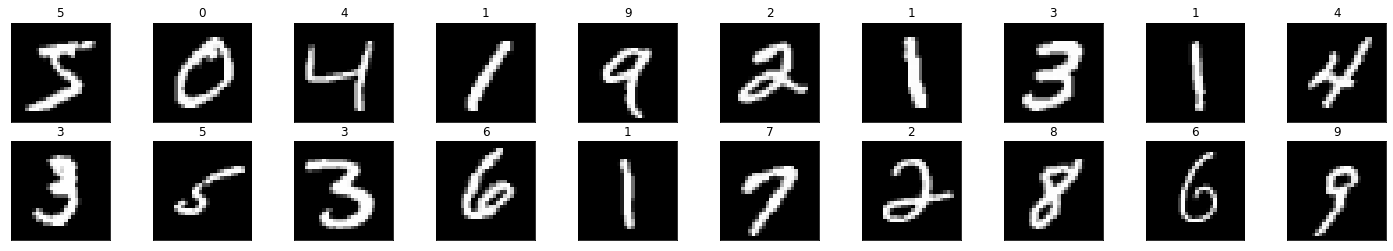

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

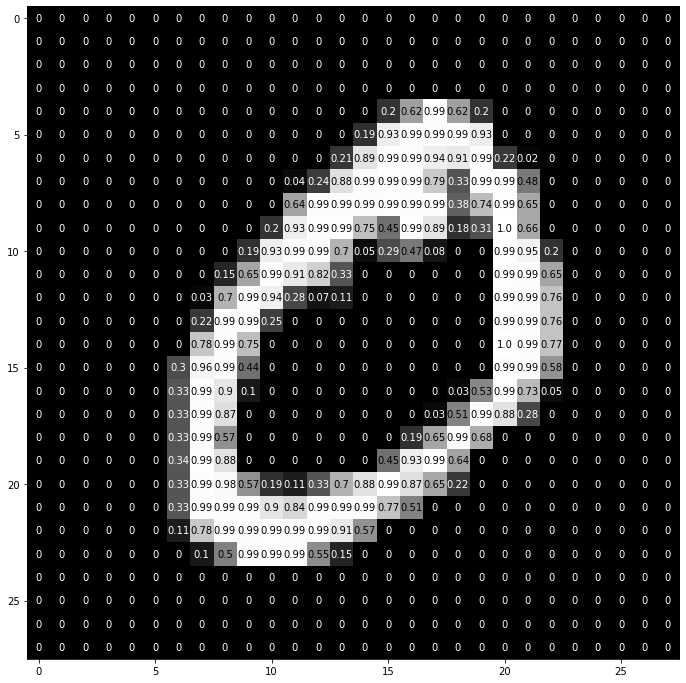

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [6]:
## TODO: Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [7]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.653115
Epoch: 2 	Training Loss: 0.566982
Epoch: 3 	Training Loss: 0.422586
Epoch: 4 	Training Loss: 0.365317
Epoch: 5 	Training Loss: 0.328692
Epoch: 6 	Training Loss: 0.300044
Epoch: 7 	Training Loss: 0.278852
Epoch: 8 	Training Loss: 0.258544
Epoch: 9 	Training Loss: 0.241284
Epoch: 10 	Training Loss: 0.226551
Epoch: 11 	Training Loss: 0.213579
Epoch: 12 	Training Loss: 0.200240
Epoch: 13 	Training Loss: 0.189039
Epoch: 14 	Training Loss: 0.180018
Epoch: 15 	Training Loss: 0.170449
Epoch: 16 	Training Loss: 0.162577
Epoch: 17 	Training Loss: 0.156446
Epoch: 18 	Training Loss: 0.149550
Epoch: 19 	Training Loss: 0.141734
Epoch: 20 	Training Loss: 0.137933
Epoch: 21 	Training Loss: 0.132202
Epoch: 22 	Training Loss: 0.126229
Epoch: 23 	Training Loss: 0.121827
Epoch: 24 	Training Loss: 0.116457
Epoch: 25 	Training Loss: 0.111628
Epoch: 26 	Training Loss: 0.108681
Epoch: 27 	Training Loss: 0.105655
Epoch: 28 	Training Loss: 0.102628
Epoch: 29 	Training Loss: 0.0

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [8]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.090945

Test Accuracy of     0: 98% (967/980)
Test Accuracy of     1: 98% (1122/1135)
Test Accuracy of     2: 97% (1003/1032)
Test Accuracy of     3: 97% (981/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 96% (864/892)
Test Accuracy of     6: 97% (933/958)
Test Accuracy of     7: 96% (992/1028)
Test Accuracy of     8: 96% (937/974)
Test Accuracy of     9: 95% (963/1009)

Test Accuracy (Overall): 97% (9716/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

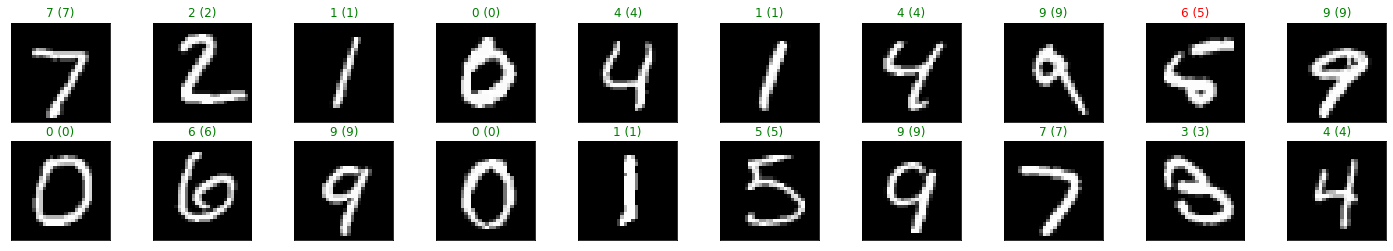

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Model with validation set

In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', download=True, train=True, transform=transform)
test_data = datasets.MNIST(root='data', download=True, train=False, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

In [4]:
from torch import nn

model = nn.Sequential(nn.Linear(28*28, 512),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(512, 512),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(512, 10)
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=True)
)


In [5]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

In [8]:
epochs = 20
model.train()

valid_loss_min = np.Inf

for e in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0
  for data, classes in train_loader:
    data = data.view(data.shape[0], -1)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, classes)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()*data.size(0)

  model.eval()

  for data, classes in valid_loader:
    data = data.view(data.shape[0],-1)
    output = model(data)
    loss = criterion(output, classes)
    valid_loss += loss.item()*data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  print("Epoch: {} \t Training Loss: {:.6f} \tValidation Loss: {:.6f}".format(
      e+1, train_loss, valid_loss
  ))

  if valid_loss <= valid_loss_min:
    print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ....".format(
        valid_loss_min, valid_loss
    ))
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss

Epoch: 1 	 Training Loss: 0.682850 	Validation Loss: 0.489927
Validation loss decreased (inf --> 0.489927). Saving model ....
Epoch: 2 	 Training Loss: 0.426364 	Validation Loss: 0.388093
Validation loss decreased (0.489927 --> 0.388093). Saving model ....
Epoch: 3 	 Training Loss: 0.362256 	Validation Loss: 0.345330
Validation loss decreased (0.388093 --> 0.345330). Saving model ....
Epoch: 4 	 Training Loss: 0.328284 	Validation Loss: 0.321052
Validation loss decreased (0.345330 --> 0.321052). Saving model ....
Epoch: 5 	 Training Loss: 0.304845 	Validation Loss: 0.299033
Validation loss decreased (0.321052 --> 0.299033). Saving model ....
Epoch: 6 	 Training Loss: 0.285923 	Validation Loss: 0.282294
Validation loss decreased (0.299033 --> 0.282294). Saving model ....
Epoch: 7 	 Training Loss: 0.269373 	Validation Loss: 0.269191
Validation loss decreased (0.282294 --> 0.269191). Saving model ....
Epoch: 8 	 Training Loss: 0.254839 	Validation Loss: 0.255948
Validation loss decreased 

In [46]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [69]:
test_loss = 0.0
class_correct = [0.] * 10
class_total = [0.] * 10

model.eval()

for data, target in test_loader:
  data = data.view(data.shape[0], -1) ##to change the shape of the data as required by the model
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0) #the entropy loss is the average values, hence we mutiply with the no.of elements
  _, pred = torch.max(output,1)  #this gives the max values across the row and the index of that
  correct = np.squeeze(pred.eq(target.view_as(pred))) ##checks whether pred==target
  for i in range(len(target)):
    label = target[i]
    class_correct[label] += correct[i].item() ##item gives only the value
    class_total[label] += 1

test_loss = test_loss / len(test_loader.sampler)
print('Test loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (
        str(i), 100 * class_correct[i] / class_total[i],
        class_correct[i], class_total[i]))
  else:
    print('Test accuracy of %5s: N/A (no training examples)' % (str(i)))
  
print('\nTest accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test loss: 0.148003

Test accuracy of     0: 98% (967/980)
Test accuracy of     1: 98% (1116/1135)
Test accuracy of     2: 95% (984/1032)
Test accuracy of     3: 96% (970/1010)
Test accuracy of     4: 96% (946/982)
Test accuracy of     5: 94% (844/892)
Test accuracy of     6: 96% (925/958)
Test accuracy of     7: 94% (974/1028)
Test accuracy of     8: 93% (907/974)
Test accuracy of     9: 92% (932/1009)

Test accuracy (Overall): 95% (9565/10000)


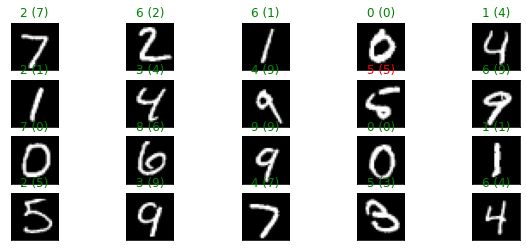

In [70]:
import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))
imagee = images.view(images.shape[0], -1)
output = model(imagee)
_, preds = torch.max(output,1)
images = images.numpy()  ##converting tensor to numpy

fig = plt.figure(figsize=(10,4))
for idx in np.arange(20):
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title("{} ({})".format(str(pred[idx].item()), str(labels[idx].item())), 
  color=("green" if preds[idx]==labels[idx] else "red"))

